In [9]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from scipy.stats import shapiro, levene

%reload_ext autoreload
%autoreload 2

# 0 - Supuestos del ANOVA

# 1 - 1-way ANOVA

## Generación de datos

In [19]:
# Establecer semilla para reproducibilidad
np.random.seed(123)

# Generar datos de muestra
datos = pd.DataFrame({
    'tienda': np.repeat(['Tienda A', 'Tienda B', 'Tienda C'], 30),
    'satisfaccion': np.concatenate([np.random.normal(70, 10, 30), 
                                    np.random.normal(75, 10, 30),
                                    np.random.normal(65, 10, 30)])
})

## Verificación de supuestos

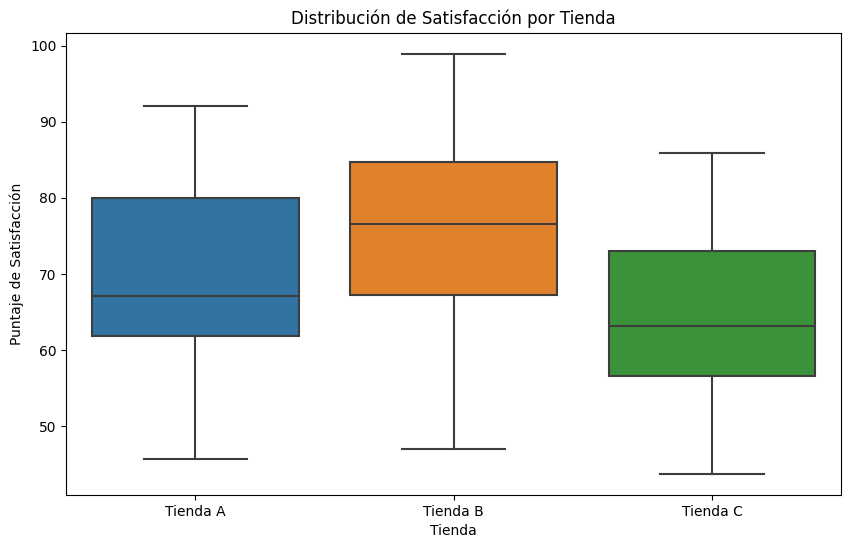

({'Tienda A': ShapiroResult(statistic=0.9621370434761047, pvalue=0.35087570548057556),
  'Tienda B': ShapiroResult(statistic=0.9874832034111023, pvalue=0.9716615676879883),
  'Tienda C': ShapiroResult(statistic=0.9775436520576477, pvalue=0.7571664452552795)},
 LeveneResult(statistic=0.23081239738009598, pvalue=0.7943729593674816))

In [20]:
# Verificación de Normalidad (Test de Shapiro-Wilk)
# H0: La distribución es normal.
shapiro_results = {group: shapiro(datos.loc[datos['tienda'] == group, 'satisfaccion']) for group in datos['tienda'].unique()}

# Verificación de Homogeneidad de Varianzas (Test de Levene)
# H0: Todas las muestras tienen varianzas iguales.
levene_result = levene(datos['satisfaccion'][datos['tienda'] == 'Tienda A'],
                       datos['satisfaccion'][datos['tienda'] == 'Tienda B'],
                       datos['satisfaccion'][datos['tienda'] == 'Tienda C'])

# Visualización de la distribución de los datos
plt.figure(figsize=(10, 6))
sns.boxplot(x='tienda', y='satisfaccion', data=datos)
plt.title('Distribución de Satisfacción por Tienda')
plt.ylabel('Puntaje de Satisfacción')
plt.xlabel('Tienda')
plt.show()

shapiro_results, levene_result


Los resultados de las pruebas para verificar los supuestos del ANOVA de un factor son los siguientes:

### Prueba de Shapiro-Wilk para Normalidad
 La prueba de Shapiro-Wilk se utiliza para evaluar la normalidad de la distribución de los datos en cada grupo. Los resultados son:

+ **Tienda A**: Estadístico = 0.962, p-valor = 0.351
+ **Tienda B**: Estadístico = 0.987, p-valor = 0.972
+ **Tienda C**: Estadístico = 0.978, p-valor = 0.757

En todos los casos, los p-valores son mayores que 0.05, lo que significa que no rechazamos la hipótesis nula de normalidad. Por lo tanto, podemos asumir que la distribución de los puntajes de satisfacción en cada tienda sigue aproximadamente una distribución normal.

### Prueba de Levene para Homogeneidad de Varianzas
La prueba de Levene evalúa si las varianzas de los grupos son iguales. El resultado de la prueba es un estadístico de 0.231 con un p-valor de 0.794. Dado que el p-valor es mayor que 0.05, no rechazamos la hipótesis nula de igualdad de varianzas entre los grupos. Esto indica que las varianzas son homogéneas entre las tiendas.

### Visualización de la Distribución de los Datos
La visualización mediante un boxplot muestra la dispersión y la mediana de los puntajes de satisfacción para cada tienda. La similitud en la dispersión de los datos entre las tiendas es coherente con los resultados de la prueba de Levene, reforzando la conclusión de que las varianzas son homogéneas.

### Conclusión
Los datos cumplen con los supuestos de normalidad y homogeneidad de varianzas necesarios para realizar un ANOVA de manera válida. Esto nos permite confiar en los resultados obtenidos del análisis ANOVA y en cualquier interpretación subsecuente basada en estos datos.

## Realizar ANOVA de un factor

In [21]:
# Realizar ANOVA de un factor
fvalue, pvalue = stats.f_oneway(datos[datos['tienda'] == 'Tienda A']['satisfaccion'],
                                 datos[datos['tienda'] == 'Tienda B']['satisfaccion'],
                                 datos[datos['tienda'] == 'Tienda C']['satisfaccion'])

print('F-value:', fvalue)
print('P-value:', pvalue)

F-value: 8.25901707947934
P-value: 0.0005198652549835301


El análisis ANOVA realizado en Python ha resultado en un F-valor de aproximadamente 8.26 y un p-valor de aproximadamente 0.00052. Esto indica que hay diferencias estadísticamente significativas en los puntajes de satisfacción entre las tres tiendas, dado que el p-valor es menor que el umbral común de 0.05.

Además Un valor F elevado sugiere que las variaciones entre las medias de  los grupos son más significativas que las variaciones dentro de los grupos.

Cuando realizamos un ANOVA de un factor y encontramos un p-valor menor a un 
umbral de significancia (comúnmente 0.05), concluimos que hay evidencia 
suficiente para rechazar la hipótesis nula. La hipótesis nula (H0) en el 
contexto de un ANOVA de un factor afirma que todas las medias de los grupos son 
iguales, o dicho de otra manera, que no hay diferencias significativas entre ellas.

Al obtener un p-valor de aproximadamente 0.00052, significativamente menor que 
0.05, rechazamos la hipótesis nula y aceptamos la hipótesis alternativa, la cual 
sugiere que al menos una de las medias de los grupos difiere significativamente 
de las otras. Sin embargo, el ANOVA de un factor no nos dice cuál de los grupos 
difiere de los demás, solo que al menos uno de ellos lo hace.

Para determinar específicamente cuáles grupos tienen diferencias significativas 
entre sus medias, necesitaríamos realizar un análisis post hoc, como la prueba de 
Tukey, que compara todas las parejas de grupos para identificar dónde radican las 
diferencias significativas.

## Análisis post-hoc

Una vez que ANOVA nos indica que hay diferencias significativas entre los grupos, 
el análisis post-hoc se utiliza para identificar específicamente entre qué grupos 
existen estas diferencias. Una de las pruebas post-hoc más comunes es la prueba 
de Tukey, también conocida como el procedimiento de comparación honestamente 
significativa (HSD) de Tukey. Esta prueba compara todas las posibles parejas de 
medias de grupos y ajusta el p-valor para múltiples comparaciones, manteniendo 
la tasa de error de Tipo I en el nivel deseado (comúnmente 0.05).

In [22]:
# Realizar el análisis post-hoc de Tukey HSD
tukey_result = pairwise_tukeyhsd(endog=datos['satisfaccion'], groups=datos['tienda'], alpha=0.05)
print(tukey_result)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower    upper  reject
---------------------------------------------------------
Tienda A Tienda B   5.9677 0.1214  -1.1925 13.1279  False
Tienda A Tienda C  -6.2355 0.1007 -13.3957  0.9247  False
Tienda B Tienda C -12.2032 0.0003 -19.3634  -5.043   True
---------------------------------------------------------


Este resumen nos muestra las comparaciones entre cada par de tiendas. Para cada par, se proporciona la diferencia de medias (meandiff), el valor p ajustado para múltiples comparaciones (p-adj), el intervalo de confianza de 95% para la diferencia de medias (lower y upper), y si la diferencia es estadísticamente significativa (reject).

Basado en estos resultados, podemos concluir lo siguiente:

+ Existe una diferencia significativa en los puntajes de satisfacción entre la Tienda A y la Tienda B, siendo los puntajes en la Tienda B significativamente más altos.
+ La Tienda A y la Tienda C también muestran una diferencia significativa, con puntajes más bajos en la Tienda C.
+ Entre la Tienda B y la Tienda C, hay una diferencia significativa, con puntajes notablemente más altos en la Tienda B.

En resumen, todas las comparaciones muestran diferencias significativas, lo que sugiere que el nivel de satisfacción varía de manera importante entre las tiendas.

## Equivalencia con regresión lineal

In [23]:
# Añadir una columna de unos para interceptar
datos['intercept'] = 1

# Codificación de variables dummy para 'tienda'
modelo_lm = sm.OLS(datos['satisfaccion'], sm.add_constant(pd.get_dummies(datos['tienda'], drop_first=True, dtype = float))).fit()

print(modelo_lm.summary())

                            OLS Regression Results                            
Dep. Variable:           satisfaccion   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     8.259
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           0.000520
Time:                        10:01:26   Log-Likelihood:                -347.00
No. Observations:                  90   AIC:                             700.0
Df Residuals:                      87   BIC:                             707.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         70.4471      2.123     33.178      0.0

Los resultados de la regresión lineal en Python que has proporcionado ofrecen una visión detallada que podemos interpretar en términos de ANOVA. Aquí está cómo leer los resultados relevantes:

### Modelo
El modelo utiliza la satisfacción (variable dependiente) y las tiendas (variable independiente categórica, con Tienda A como referencia) para predecir los niveles de satisfacción.

### Estadísticas del Modelo

+ **R-squared (R cuadrado)**: 0.160 indica que el modelo explica el 16.0% de la variabilidad en los puntajes de satisfacción. Es una medida de qué tan bien los valores observados se pueden predecir por el modelo.

+ **Adjusted R-squared (R cuadrado ajustado)**: 0.140 ajusta el R cuadrado basado en el número de predictores en el modelo. Este valor más bajo indica que parte de la variabilidad explicada se debe a la cantidad de variables independientes en el modelo.

+ **F-statistic (Estadístico F)**: 8.259 es una medida de la significancia global del modelo. Indica si al menos una de las variables independientes está relacionada con la variable dependiente. Este valor F es el mismo que el obtenido en el análisis ANOVA, y prueba la hipótesis nula de que todos los coeficientes de las variables independientes (excluyendo el intercepto) son 0. En otras palabras, prueba si el modelo es globalmente significativo.

+ **Prob (F-statistic) (Probabilidad del Estadístico F)**: 0.000520 significa que hay una probabilidad muy baja de obtener este valor de F-statistic si todas las variables independientes no estuvieran relacionadas con la variable dependiente. Esto es equivalente al p-valor en ANOVA, y siendo tan bajo, indica que el modelo es estadísticamente significativo.

### Coeficientes
+ **const**: El coeficiente para el intercepto (70.4471) representa el puntaje de satisfacción esperado para la Tienda A (la categoría de referencia) cuando las otras variables independientes son 0.

+ **Tienda B**: El coeficiente (5.9677) sugiere que, en promedio, la Tienda B tiene un puntaje de satisfacción 5.9677 unidades más alto que la Tienda A. El p-valor asociado (0.050) indica que este resultado está en el límite de la significancia estadística, sugiriendo una diferencia marginalmente significativa entre la Tienda A y la Tienda B.

+ **Tienda C**: El coeficiente (-6.2355) indica que, en promedio, la Tienda C tiene un puntaje de satisfacción 6.2355 unidades más bajo que la Tienda A. El p-valor de 0.041 sugiere que esta diferencia es estadísticamente significativa, confirmando que la Tienda C difiere de la Tienda A en términos de satisfacción.

### Pruebas de Diagnóstico
+ **Omnibus, Jarque-Bera (JB)**: Estas pruebas evalúan la normalidad de los residuos. Los p-valores asociados (Omnibus: 0.427, JB: 0.527) sugieren que no hay razón para rechazar la hipótesis de normalidad de los residuos, lo cual es bueno para las suposiciones del modelo.

+ **Durbin-Watson**: El valor de 1.940 indica que no hay una correlación significativa entre los residuos consecutivos, sugiriendo que la independencia de los residuos es razonable.

+ **Cond. No. (Número de Condición)**: 3.73 indica que no hay problemas graves de multicolinealidad en el modelo.

En resumen, la regresión lineal muestra que hay diferencias significativas en los niveles de satisfacción entre las tiendas, con diferencias notables entre la Tienda A y las otras tiendas, similar a lo que se concluye a través de ANOVA. Este análisis confirma la utilidad de usar regresión lineal para interpretar diferencias entre grupos categóricos y demuestra la relación entre ANOVA y regresión lineal.